Run Compositional Data Analysis following scCoda Bayesian approach. For that I will use the whole dataset, with whole cells and then I will annotate the Barcodes of T cells based on the subclustering I have performed. 
https://www.nature.com/articles/s41467-021-27150-6

Compositional data are nonnegative data carrying relative, rather than absolute, information—these are often data with a constant-sum constraint on the sample values, for example, proportions or percentages summing to 1% or 100%, respectively. Ratios between components of a composition are important since they are unaffected by the particular set of components chosen. Logarithms of ratios (logratios) are the fundamental transformation in the ratio approach to compositional data analysis—all data thus need to be strictly positive, so that zero values present a major problem.

https://www.annualreviews.org/doi/pdf/10.1146/annurev-statistics-042720-124436

By “compositional,” we mean that the abun- dance of any 1 nucleotide fragment is only interpretable rela- tive to another. This property emerges from the sequencer it- self; the sequencer, by design, can only sequence a fixed num- ber of nucleotide fragments. Consequently, the final number of fragments sequenced is constrained to an arbitrary limit so that doubling the input material does not double the total number of counts. This constraint also means that an increase in the pres- ence of any 1 nucleotide fragment necessarily decreases the ob- served abundance of all other transcripts, and applies to bulk and single-cell sequencing data alike. It is especially problem- atic when comparing cells that produce more total RNA than their comparator (e.g., high–c-Myc cells, which up-regulate 90% of all transcripts without commensurate down-regulation). However, even if a sequencer could directly sequence every RNA molecule within a cell, the cells themselves are compositional because of the volume and energy constraints that limit RNA synthesis, as evidenced by the observation that smaller cells of a single type contain proportionally less total messenger RNA (mRNA).

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6755255/pdf/giz107.pdf


In [52]:
# Setup
import importlib
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import seaborn as sns


from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

import sccoda.datasets as scd
import anndata as ad

from scanpro import scanpro, anova, t_test
from scanpro.linear_model import create_design
from scanpro.get_transformed_props import get_transformed_props


In [53]:
#load harmony integrated data.
harmony_int_annot = '../harmony_integrated_annotated.h5ad'

# Read the HDF5 file into a DataFrame
integrated_harmony = ad.read_h5ad(harmony_int_annot)

In [54]:
#load tcell data.
t_cell_re_clustered = '../t_cell_analysis/t_cell_data_reclustered.h5ad'

# Read the HDF5 file into a DataFrame
t_cell_data = ad.read_h5ad(t_cell_re_clustered)

In [55]:
#now add t cell annotation to the observation part
t_cell_data.obs['Barcodes']=t_cell_data.obs.index

In [56]:
t_data_info=t_cell_data.obs[['Barcodes','T_cell_type_fine']]
#rename T_cell_type_fine to concat with macrophages
t_data_info = t_data_info.rename(columns={'T_cell_type_fine': 'New_clustering'})

In [57]:
#sine t data is not the only one we have reclustered load also megacaryocytes data. 
#load megacaryocytes data.
macrophages_clustered = '../macrophages_data/macrophages_data_reclustered.h5ad'

# Read the HDF5 file into a DataFrame
macrophages_data = ad.read_h5ad(macrophages_clustered)
macrophages_data.obs['Barcodes']=macrophages_data.obs.index


In [58]:
macro_info=macrophages_data.obs[['Barcodes','Myeloid_granular']]
macro_info = macro_info.rename(columns={'Myeloid_granular': 'New_clustering'})

In [59]:
#concat tcells and macrophages
concated_data=pd.concat([t_data_info, macro_info], ignore_index=True)

In [60]:
integrated_harmony.obs['Barcodes']=integrated_harmony.obs.index

In [61]:
#i need to add the bcells too since we have change the annoation.

bceels_clustered = '../b_cell_analysis/b_cell_data_reclustered.h5ad'

# Read the HDF5 file into a DataFrame
bcell_data = ad.read_h5ad(bceels_clustered)
bcell_data.obs['Barcodes']=bcell_data.obs.index


In [62]:
bcell_info=bcell_data.obs[['Barcodes','Cell_type_generic_3']]
bcell_info = bcell_info.rename(columns={'Cell_type_generic_3': 'New_clustering'})

In [63]:
#concat all cells types
concated_data2=pd.concat([concated_data, bcell_info], ignore_index=True)


In [64]:
concated_data2

,Barcodes,New_clustering
0,AAACCCACACCAATTG-1-0,Tregs_1
1,AAACCCAGTATGGTAA-1-0,Tregs_2
2,AAACCCAGTGTCACAT-1-0,T_ribosomal
3,AAACCCATCGCACTCT-1-0,Naive_1
4,AAACCCATCTCGAGTA-1-0,Naive_1
...,...,...
48209,TTTGGAGTCGGTAGAG-1-5,B_cells_1
48210,TTTGGTTCAAGGGTCA-1-5,B_cells_1
48211,TTTGTTGGTCGTTATG-1-5,B_cells_1
48212,TTTGTTGTCACCATGA-1-5,B_cells_3


In [65]:
new_integrated_harmony=integrated_harmony.copy()

In [66]:
sorted_barcodes = new_integrated_harmony.obs.index

In [67]:
new_integrated_harmony.obs = pd.merge(new_integrated_harmony.obs,concated_data2, on='Barcodes', how='outer')

In [68]:
new_integrated_harmony.obs.index=new_integrated_harmony.obs['Barcodes']

In [69]:
#now sort again the table based on barcodes because when merging everything changed
new_integrated_harmony.obs=new_integrated_harmony.obs.reindex(sorted_barcodes)

In [70]:
new_integrated_harmony.obs['New_clustering'] = new_integrated_harmony.obs['New_clustering'].astype(str)
new_integrated_harmony.obs['Cell_type_generic_2'] = new_integrated_harmony.obs['Cell_type_generic_2'].astype(str)

In [71]:
new_integrated_harmony.layers['log10']=new_integrated_harmony.raw.X.copy() #in our case we already have the normalized log transformed in .raw

In [72]:
new_integrated_harmony.obs.loc[new_integrated_harmony.obs['New_clustering']=='nan', 'New_clustering'] = new_integrated_harmony.obs['Cell_type_generic_2']

In [73]:
new_integrated_harmony.obs['New_clustering'] = new_integrated_harmony.obs['New_clustering'].replace({
    'Naive_1': 'N_1',
    'Naive_2': 'N_2',
    'T_cd8': 'CD8',
    'T_effector':'EFF',
    'T_effector_cytotoxic_1': 'eCTL_1',
    'T_effector_cytotoxic_2':'eCTL_2',
    'T_ribosomal': 'Ribo',
    'Tfh':'FH',
    'Th1': 'H',
    'Tregs_1': 'Reg_1',
    'Tregs_2':'Reg_2'
})

In [74]:
# save this new integrated with new annotation object
#save_for_shinny = 'integrated_harmony_new_annot_shinny.h5ad'
#new_integrated_harmony.write(save_for_shinny)

In [75]:
#load harmony integrated data.
#save_for_shinny = '../integrated_harmony_new_annot_shinny.h5ad'

# Read the HDF5 file into a DataFrame
#new_integrated_harmony = ad.read_h5ad(save_for_shinny)

In [76]:
new_integrated_harmony.obs["New_clustering"].value_counts()

New_clustering
B_cells_1        9970
B_cells_3        5670
N_1              4798
Reg_1            4263
Reg_2            3855
N_2              3120
B_cells_2        2904
Ribo             2525
CD8              2364
eCTL_1           2037
EFF              1637
eCTL_2           1325
NK_1             1250
H                 965
FH                574
B_cells_4         518
NKT_cells         464
NK_2              402
Plasma_1          380
Monocytes_1       222
cDC_1             194
Macrophages_2     132
Macrophages_3     115
Eosinophils       102
Macrophages_4      56
pDC_1              56
Macrophages_5      39
Macrophages_1      31
Name: count, dtype: int64

In [77]:
# using scanpro i can get by default number of cell per sample in a dataframe
counts, props, prop_trans = get_transformed_props(new_integrated_harmony, sample_col='Sample', cluster_col='New_clustering', transform='logit')


In [78]:
props

New_clustering,B_cells_1,B_cells_2,B_cells_3,B_cells_4,CD8,EFF,Eosinophils,FH,H,Macrophages_1,...,N_1,N_2,Plasma_1,Reg_1,Reg_2,Ribo,cDC_1,eCTL_1,eCTL_2,pDC_1
Sample,,,,,,,,,,,,,,,,,,,,,
out_Mouse_4,0.423437,0.084456,0.235271,0.019253,0.017328,0.011680,0.000385,0.004749,0.006418,0.000128,...,0.037479,0.025799,0.004621,0.027981,0.032987,0.017199,0.002695,0.008856,0.006161,0.001797
out_Mouse_5,0.100221,0.016601,0.050541,0.006026,0.031112,0.034432,0.005534,0.014634,0.027791,0.001353,...,0.151008,0.091982,0.007747,0.105386,0.107600,0.078578,0.006026,0.046114,0.032833,0.001107
out_Mouse_8,0.236737,0.132877,0.145205,0.011706,0.033748,0.018431,0.003611,0.005230,0.007846,0.000249,...,0.045704,0.026027,0.010710,0.100249,0.105729,0.023039,0.004110,0.017310,0.019427,0.000498
out_Mouse_11,0.051180,0.008273,0.020516,0.005074,0.059563,0.057688,0.001655,0.013677,0.034745,0.001544,...,0.128392,0.095963,0.007721,0.109640,0.110413,0.057578,0.008383,0.080631,0.067064,0.001213
out_Mouse_13,0.136718,0.030192,0.072316,0.005722,0.078524,0.051863,0.000365,0.015705,0.026418,0.000122,...,0.117482,0.064767,0.002922,0.104821,0.071585,0.069150,0.001339,0.075116,0.025566,0.000487
out_Mouse_23,0.271093,0.082541,0.169433,0.015112,0.059531,0.019347,0.000801,0.014081,0.010761,0.000229,...,0.089525,0.064110,0.011563,0.060446,0.032627,0.054608,0.000458,0.012135,0.004121,0.001603


In [79]:
counts['Sample']=pd.DataFrame(counts).index

In [80]:
counts

New_clustering,B_cells_1,B_cells_2,B_cells_3,B_cells_4,CD8,EFF,Eosinophils,FH,H,Macrophages_1,...,N_2,Plasma_1,Reg_1,Reg_2,Ribo,cDC_1,eCTL_1,eCTL_2,pDC_1,Sample
Sample,,,,,,,,,,,,,,,,,,,,,
out_Mouse_4,3299,658,1833,150,135,91,3,37,50,1,...,201,36,218,257,134,21,69,48,14,out_Mouse_4
out_Mouse_5,815,135,411,49,253,280,45,119,226,11,...,748,63,857,875,639,49,375,267,9,out_Mouse_5
out_Mouse_8,1901,1067,1166,94,271,148,29,42,63,2,...,209,86,805,849,185,33,139,156,4,out_Mouse_8
out_Mouse_11,464,75,186,46,540,523,15,124,315,14,...,870,70,994,1001,522,76,731,608,11,out_Mouse_11
out_Mouse_13,1123,248,594,47,645,426,3,129,217,1,...,532,24,861,588,568,11,617,210,4,out_Mouse_13
out_Mouse_23,2368,721,1480,132,520,169,7,123,94,2,...,560,101,528,285,477,4,106,36,14,out_Mouse_23


In [81]:
#save proportion datatable for all cell types.
counts.to_csv('sample_count_per_cell_type.csv', index=False)

In [82]:
sccoda_anndata= dat.from_pandas(counts, covariate_columns=["Sample"])
#now add to observation the condition of each mouse
sccoda_anndata

AnnData object with n_obs × n_vars = 6 × 28
    obs: 'Sample'

In [83]:
# add information of the condition of each mouse sample. So to merged_data.obs add a new column that will display cart or cart+radiation
sccoda_anndata.obs["Condition"] = "Cy/mCART19"

# Define conditions for specific samples
conditions = {
    "out_Mouse_5": "Cy/LD-TBI/mCART19",
    "out_Mouse_11": "Cy/LD-TBI/mCART19",
    "out_Mouse_13": "Cy/LD-TBI/mCART19",
}

# Update 'Condition' column based on conditions
for sample, condition in conditions.items():
    sccoda_anndata.obs['Condition'] = np.where(sccoda_anndata.obs['Sample'] == sample, condition, sccoda_anndata.obs['Condition'])

In [84]:
t_Cell_types=['N_1', 'N_2', 'CD8', 'EFF', 'eCTL_1', 'eCTL_2', 'Ribo', 'FH', 'H','Reg_1', 'Reg_2' ]
b_cell_types=['B_cells_1','B_cell_3','B_memory','B_cell_ribo','Plasma_1', 'NKT_cells']
myeloid_cell_types=['Monocytes_1','cDC_1','Macrophages_3','Macrophages_2','pDC_1','Macrophages_5','Macrophages_4','Macrophages_1']

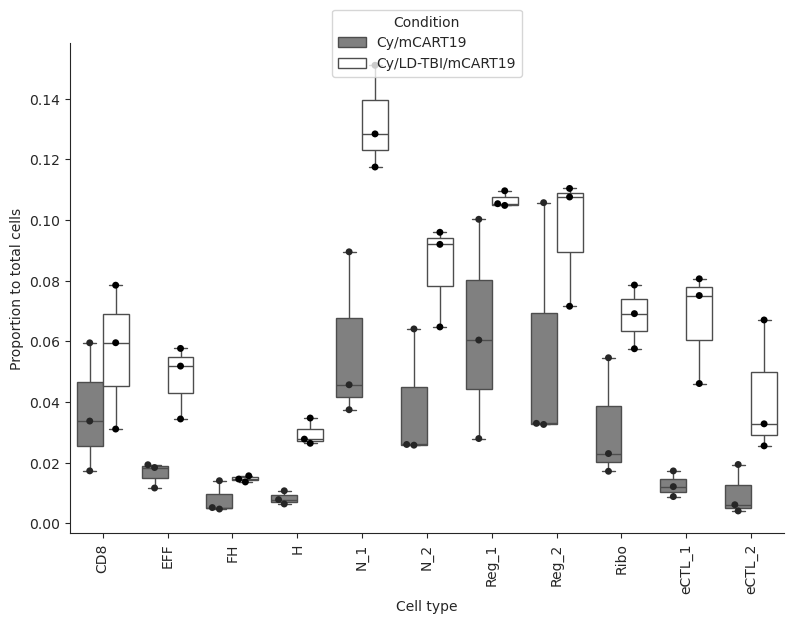

In [85]:
# Create the plot and retrieve the Axes object
ax = viz.boxplots(
    sccoda_anndata,
    feature_name="Condition",
    figsize=[10, 6],
    plot_legend='T cell proportions',
    add_dots=True,
    cell_types=t_Cell_types,
    cmap=['gray', 'white']
)

# Customize the y-axis label
ax.set_ylabel('Proportion to total cells')

# Remove gridlines on top and right
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust legend position to place it in the middle
legend = ax.get_legend()  # Retrieve the existing legend
if legend is not None:  # Check if the legend exists
    legend.set_bbox_to_anchor((0.5, 1))  # Place legend in the middle of the plot
    legend.set_loc("center")  # Align legend to the center

# Optionally disable the grid
ax.grid(False)

# Show the modified plot
plt.show()




The scCODA model requires a cell type to be set as the reference category. However, choosing this cell type is often difficult. A good first choice is a referenece cell type that closely preserves the changes in relative abundance during the compositional analysis.

For this, it is important that the reference cell type is not rare, to avoid large relative changes being caused by small absolute changes. Also, the relative abundance of the reference should vary as little as possible across all samples.

The visualization viz.rel_abundance_dispersion_plot shows the presence (share of non-zero samples) over all samples for each cell type versus its dispersion in relative abundance. Cell types that have a higher presence than a certain threshold (default 0.9) are suitable candidates for the reference and thus colored.

Model setup and inference

The formula parameter. It specifies how the covariates are used in the model. It can process R-style formulas via the patsy package, e.g. formula="Cov1 + Cov2 + Cov3". Here, we simply use the “Condition” covariate of our dataset

The reference_cell_type parameter is used to specify a cell type that is believed to be unchanged by the covariates in formula. This is necessary, because compositional analysis must always be performed relative to a reference (See Büttner, Ostner et al., 2021 for a more thorough explanation). If no knowledge about such a cell type exists prior to the analysis, taking a cell type that has a nearly constant relative abundance over all samples is often a good choice. It is also possible to let scCODA find a suited reference cell type by using reference_cell_type="automatic". Here, we take Goblet cells as the reference.

In [86]:
model_sccoda_anndata = mod.CompositionalAnalysis(sccoda_anndata, formula="Condition", reference_cell_type="automatic")


Automatic reference selection! Reference cell type set to pDC_1
Zero counts encountered in data! Added a pseudocount of 0.5.


In [87]:
model_sccoda_anndata

In [88]:
# Run MCMC
sccoda_anndata_results = model_sccoda_anndata.sample_hmc()

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:58<00:00, 340.88it/s]


MCMC sampling finished. (74.800 sec)
Acceptance rate: 70.1%


In [89]:
sccoda_anndata_results.summary()

Compositional Analysis summary:

Data: 6 samples, 28 cell types
Reference index: 27
Formula: Condition

Intercepts:
               Final Parameter  Expected Sample
Cell Type                                      
B_cells_1                2.464       799.181932
B_cells_2                1.007       186.156668
B_cells_3                1.786       405.689715
B_cells_4                0.253        87.583149
CD8                      1.955       480.385362
EFF                      1.684       366.349802
Eosinophils             -0.649        35.537505
FH                       0.724       140.272733
H                        1.212       228.511976
Macrophages_1           -1.111        22.389422
Macrophages_2           -0.421        44.638139
Macrophages_3           -0.529        40.068425
Macrophages_4           -0.928        26.885541
Macrophages_5           -1.018        24.571534
Monocytes_1             -0.084        62.526384
NKT_cells                0.419       103.398310
NK_1                

In [119]:
res_scoda_fdr0_0_5=sccoda_anndata_results.effect_df
res_scoda_fdr0_0_5

Final Parameter  HDI 3%  HDI 97%  \
Covariate               Cell Type                                         
Condition[T.Cy/mCART19] B_cells_1             1.702245   1.284    2.138   
                        B_cells_2             2.017527   1.328    2.709   
                        B_cells_3             1.860874   1.315    2.368   
                        B_cells_4             0.959403  -0.012    1.851   
                        CD8                   0.000000  -0.537    0.655   
                        EFF                   0.000000  -1.127    0.248   
                        Eosinophils           0.000000  -1.127    1.173   
                        FH                    0.000000  -1.000    0.692   
                        H                     0.000000  -1.368    0.242   
                        Macrophages_1         0.000000  -1.331    1.034   
                        Macrophages_2         0.000000  -0.871    1.492   
                        Macrophages_3         0.000000  -1.384    0.679   
                        Macrophages_4         0.000000  -1.310    0.893   
                        Macrophages_5         0.000000  -1.344    1.066   
                        Monocytes_1           0.000000  -1.224    0.911   
                        NKT_cells             0.000000  -1.513    0.533   
                        NK_1                  0.000000  -0.707    0.749   
                        NK_2                  0.000000  -1.480    0.584   
                        N_1                   0.000000  -0.831    0.120   
                        N_2                   0.000000  -0.852    0.198   
                        Plasma_1              0.000000  -0.419    1.523   
                        Reg_1                 0.000000  -0.589    0.407   
                        Reg_2                 0.000000  -0.672    0.329   
                        Ribo                  0.000000  -0.877    0.288   
                        cDC_1                 0.000000  -1.088    0.972   
                        eCTL_1               -0.934217  -1.706   -0.234   
                        eCTL_2                0.000000  -1.619    0.039   
                        pDC_1                 0.000000   0.000    0.000   

                                          SD  Inclusion probability  \
Covariate               Cell Type                                     
Condition[T.Cy/mCART19] B_cells_1      0.230               1.000000   
                        B_cells_2      0.364               1.000000   
                        B_cells_3      0.280               1.000000   
                        B_cells_4      0.569               0.862133   
                        CD8            0.197               0.384400   
                        EFF            0.348               0.549400   
                        Eosinophils    0.396               0.432200   
                        FH             0.296               0.412267   
                        H              0.436               0.588267   
                        Macrophages_1  0.398               0.414000   
                        Macrophages_2  0.406               0.425467   
                        Macrophages_3  0.385               0.421667   
                        Macrophages_4  0.418               0.475867   
                        Macrophages_5  0.427               0.453933   
                        Monocytes_1    0.370               0.432533   
                        NKT_cells      0.403               0.430333   
                        NK_1           0.231               0.365467   
                        NK_2           0.422               0.418667   
                        N_1            0.248               0.461733   
                        N_2            0.236               0.438133   
                        Plasma_1       0.484               0.584400   
                        Reg_1          0.146               0.295800   
                        Reg_2          0.153               0.299467   
             

In [120]:
#get results from object
# Subset the dataframe based on a single row name (index)
res_dataframe = res_scoda_fdr0_0_5.loc[
    ("Condition[T.Cy/mCART19]", slice(None))  # The slice(None) allows for all values in the second level
]


In [121]:
#plot proportions using 
melted_prop=pd.melt(props, var_name="cell_type", value_name="proportion")
melted_prop["Sample_name"]=props.index.tolist() * len(props.columns)
melted_prop
#melted_prop.to_csv('ALL_data_prop.csv', index=False)

,cell_type,proportion,Sample_name
0,B_cells_1,0.423437,out_Mouse_4
1,B_cells_1,0.100221,out_Mouse_5
2,B_cells_1,0.236737,out_Mouse_8
3,B_cells_1,0.051180,out_Mouse_11
4,B_cells_1,0.136718,out_Mouse_13
...,...,...,...
163,pDC_1,0.001107,out_Mouse_5
164,pDC_1,0.000498,out_Mouse_8
165,pDC_1,0.001213,out_Mouse_11
166,pDC_1,0.000487,out_Mouse_13


In [122]:
design = create_design(data=new_integrated_harmony, sample_col='Sample', conds_col='Condition')
design

,CART_RAD,CART
Sample,,
out_Mouse_11,1.0,0.0
out_Mouse_13,1.0,0.0
out_Mouse_23,0.0,1.0
out_Mouse_4,0.0,1.0
out_Mouse_5,1.0,0.0
out_Mouse_8,0.0,1.0


In [123]:
conditions=new_integrated_harmony.obs[["Sample", "Condition"]].drop_duplicates()
conditions=conditions.rename(columns={"Sample": "Sample_name"})
melted_prop = pd.merge(melted_prop,conditions)


In [124]:
melted_prop['Condition'] = melted_prop['Condition'].replace("CART", "Cy/mCART19")
melted_prop['Condition'] = melted_prop['Condition'].replace("CART_RAD", "Cy/LD-TBI/mCART19")
melted_prop

,cell_type,proportion,Sample_name,Condition
0,B_cells_1,0.423437,out_Mouse_4,Cy/mCART19
1,B_cells_1,0.100221,out_Mouse_5,Cy/LD-TBI/mCART19
2,B_cells_1,0.236737,out_Mouse_8,Cy/mCART19
3,B_cells_1,0.051180,out_Mouse_11,Cy/LD-TBI/mCART19
4,B_cells_1,0.136718,out_Mouse_13,Cy/LD-TBI/mCART19
...,...,...,...,...
163,pDC_1,0.001107,out_Mouse_5,Cy/LD-TBI/mCART19
164,pDC_1,0.000498,out_Mouse_8,Cy/mCART19
165,pDC_1,0.001213,out_Mouse_11,Cy/LD-TBI/mCART19
166,pDC_1,0.000487,out_Mouse_13,Cy/LD-TBI/mCART19


In [125]:
scoda_Res_df = res_dataframe[['Final Parameter']]
scoda_Res_df["cell_type"]=scoda_Res_df.index 
scoda_Res_df

,Final Parameter,cell_type
Cell Type,,
B_cells_1,1.702245,B_cells_1
B_cells_2,2.017527,B_cells_2
B_cells_3,1.860874,B_cells_3
B_cells_4,0.959403,B_cells_4
CD8,0.000000,CD8
EFF,0.000000,EFF
Eosinophils,0.000000,Eosinophils
FH,0.000000,FH
H,0.000000,H


In [126]:
melted_prop=pd.merge(melted_prop,scoda_Res_df)

melted_prop

,cell_type,proportion,Sample_name,Condition,Final Parameter
0,B_cells_1,0.423437,out_Mouse_4,Cy/mCART19,1.702245
1,B_cells_1,0.100221,out_Mouse_5,Cy/LD-TBI/mCART19,1.702245
2,B_cells_1,0.236737,out_Mouse_8,Cy/mCART19,1.702245
3,B_cells_1,0.051180,out_Mouse_11,Cy/LD-TBI/mCART19,1.702245
4,B_cells_1,0.136718,out_Mouse_13,Cy/LD-TBI/mCART19,1.702245
...,...,...,...,...,...
163,pDC_1,0.001107,out_Mouse_5,Cy/LD-TBI/mCART19,0.000000
164,pDC_1,0.000498,out_Mouse_8,Cy/mCART19,0.000000
165,pDC_1,0.001213,out_Mouse_11,Cy/LD-TBI/mCART19,0.000000
166,pDC_1,0.000487,out_Mouse_13,Cy/LD-TBI/mCART19,0.000000


In [127]:
melted_prop['Condition'] = pd.Categorical(melted_prop['Condition'], categories=['Cy/mCART19','Cy/LD-TBI/mCART19'], ordered=True)
melted_prop = melted_prop.sort_values(by='Condition')
melted_prop.reset_index(drop=True, inplace=True)
melted_prop

,cell_type,proportion,Sample_name,Condition,Final Parameter
0,B_cells_1,0.423437,out_Mouse_4,Cy/mCART19,1.702245
1,N_1,0.037479,out_Mouse_4,Cy/mCART19,0.000000
2,NK_2,0.003549,out_Mouse_23,Cy/mCART19,0.000000
3,NK_2,0.001993,out_Mouse_8,Cy/mCART19,0.000000
4,NK_2,0.003722,out_Mouse_4,Cy/mCART19,0.000000
...,...,...,...,...,...
163,NK_2,0.016766,out_Mouse_11,Cy/LD-TBI/mCART19,0.000000
164,EFF,0.034432,out_Mouse_5,Cy/LD-TBI/mCART19,0.000000
165,NK_2,0.009469,out_Mouse_5,Cy/LD-TBI/mCART19,0.000000
166,N_1,0.117482,out_Mouse_13,Cy/LD-TBI/mCART19,0.000000


In [128]:
sub_melted_prop = melted_prop[melted_prop["cell_type"].isin(t_Cell_types)]
sub_melted_prop['cell_type'] = pd.Categorical(
    sub_melted_prop['cell_type'], 
    categories=['N_1', 'N_2', 'CD8', 'EFF', 'eCTL_1', 'eCTL_2', 'Ribo', 'FH', 'H','Reg_1', 'Reg_2'], 
    ordered=True
)
sub_melted_prop = sub_melted_prop.sort_values(by='cell_type')
final_parameters = sub_melted_prop[["cell_type", "Final Parameter"]].drop_duplicates()
final_parameters_list = final_parameters['Final Parameter'].tolist()

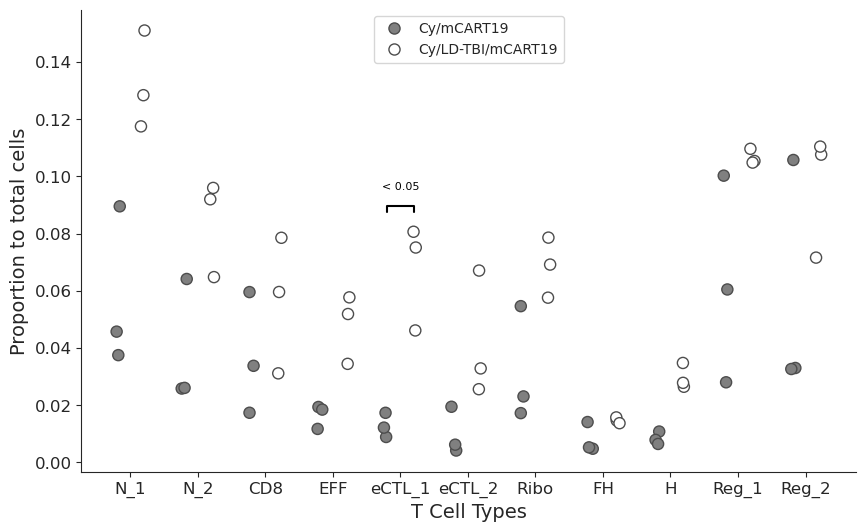

In [129]:
# Threshold and other settings
threshold = 0
plt.figure(figsize=(10, 6))

# Create the box plot
ax = sns.stripplot(
    x="cell_type", 
    y="proportion", 
    hue="Condition", 
    data=sub_melted_prop, 
    #palette=["#BF3EFF", "#FFA500"], 
    palette=["gray", "white"],
    linewidth=1, 
    dodge=True,  # Separate dots by condition
    jitter=True,  # Add jitter to avoid overlap
    size=8
)
# Get x-axis positions for each category
category_positions = {
    text.get_text(): pos for pos, text in enumerate(ax.get_xticklabels())
}

# Annotate significance
for i, param in enumerate(final_parameters_list):
    # Get the current cell type name
    cell_type = sub_melted_prop['cell_type'].cat.categories[i]  # Match plot order

     # Find the x-axis position for this cell type
    if cell_type in category_positions:
        x_pos = category_positions[cell_type]
        
        # Get max y-value for the cell type
        max_y = sub_melted_prop[sub_melted_prop["cell_type"] == cell_type]["proportion"].max()
        y = max_y + 0.007  # Add margin above the max value
        h = 0.002  # Height of the annotation line

        # Determine x-positions for the two conditions
        x1 = x_pos - 0.2  # Adjust for Condition 1
        x2 = x_pos + 0.2  # Adjust for Condition 2

        if param != threshold:
            # Draw the significance annotation
            ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, color="black")
            ax.text((x1 + x2) / 2, y + h + 0.005, "< 0.05", 
                    ha="center", va="bottom", color="black", fontsize=8)
            
        #else:
            # Handle non-significant cases (optional visual adjustment)
            #ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, color="gray")
            #ax.text((x1 + x2) / 2, y + h + 0.005, "Not-sig", 
                    #ha="center", va="bottom", color="gray", fontsize=8, style="italic")  

# Adjust legend position
legend = ax.get_legend()
if legend:
    legend.set_bbox_to_anchor((0.5, 1))
    legend.set_loc("center")

# Add labels and legend
ax.set_ylabel("Proportion to total cells", fontsize=14)
ax.set_xlabel("T Cell Types", fontsize=14)
ax.legend(title="", loc="upper center")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Rotate x-axis labels
#plt.xticks(rotation=45, ha="right")  # Rotate by 45 degrees, align to the right for readability
ax.tick_params(axis='x', labelsize=12)  # Increase x-axis tick labels
ax.tick_params(axis='y', labelsize=12)  # Increase y-axis tick labels

# Save or display the plot
plt.savefig("dotplot_2_t_cell_scCODA_for_publi.pdf", format="pdf", bbox_inches="tight")
plt.show()